In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import pickle
import os
import itertools
import datetime
import random
import missingno as msno
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer

# TSA from Statsmodels
import math
import powerlaw
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy import stats
from scipy.stats import powerlaw
from scipy.stats import lognorm, kstest,expon,powerlaw

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
pd.set_option('max_columns', 1000) 

In [2]:
SAVE_PROCESSED_DATA = True

In [3]:
scriptDir = os.getcwd()
relPath = r"../Customer Segmentation/"
sampleFilePath = os.path.join(scriptDir, relPath, 'CJ filtered.csv')
relPathOutput = r"../output/"
outputFolderPath = os.path.join(scriptDir, relPathOutput)

In [4]:
# Load AirPartner Data
df = pd.read_csv(sampleFilePath, header=0, encoding='latin1')
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (12810, 19)


# Wrangle data
- Continue with the previous part

## Converting the numerical features to scaled range
- check the min and max for each feature, if the scope is big, we need to consider to log them first and them scaled them in to 0-1.

In [5]:
print('Gross range:', df['gross'].min(), '->', df['gross'].max())
print('Total Flight Time (Dec) range:', df['Total Flight Time (Dec)'].min(), '->', df['Total Flight Time (Dec)'].max())
print('Total Distance (NMi) range:', df['Total Distance (NMi)'].min(), '->', df['Total Distance (NMi)'].max())

Gross range: 101.055431 -> 49987.09
Total Flight Time (Dec) range: 0.25 -> 70.69
Total Distance (NMi) range: 54.68 -> 28234.2


### Transform the 'gross' and 'Distance' columns into log10

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [7]:
df['gross_log'] = np.log10(df['gross'])
df['Distance_log'] = np.log10(df['Total Distance (NMi)'])
df['FlightTime_log'] = np.log10(df['Total Flight Time (Dec)'])

In [8]:
def minmaxscaler(data, columns):
        
    for column in columns:
        data['Scaled_' + column]=(data[column] - np.min(data[column])) / (np.max(data[column]) - np.min(data[column]))
    
    return data

minmaxscaler(df, columns=['gross_log', 'Distance_log', 'FlightTime_log'])

,enqid,Contactid,ownerid,companyid,Industry,Product,booked date,creation date,Flight date,Flight Year,Aircraft code,no of sectors,passengers,Total Flight Time (Dec),Total Distance (NMi),gross,Country,Round_trip,ProfitMargin(%),gross_log,Distance_log,FlightTime_log,Scaled_gross_log,Scaled_Distance_log,Scaled_FlightTime_log
0,1,3871,38,2894,Competitor company,CJ - Adhoc,9/7/2015,5/31/2007,9/17/2015,2015,"B737-400,B737-800",4,3,3.41,847.90,4230.814787,Italy,1,2,3.626424,2.928345,0.532754,0.601962,0.438828,0.462922
1,1,3871,38,2894,Competitor company,CJ - Adhoc,9/7/2015,5/31/2007,9/30/2015,2015,"B737-400,B737-800",2,1,1.42,410.87,4230.814787,Italy,0,2,3.626424,2.613704,0.152288,0.601962,0.322850,0.307719
2,1,3871,38,2894,Competitor company,CJ - Adhoc,9/7/2015,5/31/2007,10/1/2015,2015,"B737-400,B737-800",1,1,1.42,410.87,4230.814787,Italy,0,2,3.626424,2.613704,0.152288,0.601962,0.322850,0.307719
3,2,5100,110,2482,Tour Operators,CJ - Adhoc,3/1/2013,1/4/2013,2/16/2014,2014,B777-2A+,1,3,1.33,450.96,38328.977530,France,1,2,4.583527,2.654138,0.123852,0.957195,0.337754,0.296119
4,3,5123,35,2783,"Conference, Incentive, etc",CJ - Adhoc,1/24/2014,2/26/2013,5/9/2014,2014,B737-700,2,1,2.34,550.88,846.888926,Germany,1,0,2.927826,2.741057,0.369216,0.342674,0.369793,0.396210
5,3,5123,35,2783,Travel Agents,CJ - Adhoc,1/24/2014,2/26/2013,5/9/2014,2014,B737-700,2,1,2.34,550.88,846.888926,Germany,1,0,2.927826,2.741057,0.369216,0.342674,0.369793,0.396210
6,5,5100,110,2482,Tour Operators,Tour Ops,4/2/2013,4/2/2013,1/23/2014,2014,B777-3ER,2,3,19.17,8598.58,12373.968220,France,1,1,4.092509,3.934427,1.282622,0.774951,0.809672,0.768813
7,6,5100,110,2482,Tour Operators,Tour Ops,4/2/2013,4/2/2013,3/13/2014,2014,B777-3ER,2,3,19.17,8598.58,13440.410170,France,1,1,4.128413,3.934427,1.282622,0.788277,0.809672,0.768813
8,7,5100,110,2482,Tour Operators,Tour Ops,4/2/2013,4/2/2013,3/27/2014,2014,B777-3ER,2,3,19.17,8598.58,4366.875617,France,1,2,3.640171,3.934427,1.282622,0.607064,0.809672,0.768813
9,8,5100,110,2482,Tour Operators,Tour Ops,4/2/2013,4/2/2013,4/10/2014,2014,B777-3ER,2,3,19.17,8598.58,4455.482584,France,1,2,3.648895,3.934427,1.282622,0.610302,0.809672,0.768813


In [9]:
print('Gross_log range:', df['Scaled_gross_log'].median(), '->', df['Scaled_gross_log'].std())
print('Total Flight Time_log range:', df['Scaled_FlightTime_log'].median(), '->', df['Scaled_FlightTime_log'].std())
print('Total Distance_log range:', df['Scaled_Distance_log'].median(), '->', df['Scaled_Distance_log'].std())

Gross_log range: 0.4749836940165775 -> 0.1888375903679227
Total Flight Time_log range: 0.5249636606861952 -> 0.10276999402609295
Total Distance_log range: 0.5376713115388145 -> 0.1143567410924678


## Countries
- look at the countries from which orders were made

In [10]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [11]:
df_2018 = df[df['Flight Year']  == 2018]

df1 = df_2018['Country'].value_counts()
df1 = pd.DataFrame(df1)
df1 = df1.reset_index(drop=False)
temp = df_2018[['Country', 'gross']].groupby(['Country']).sum()
temp = temp.reset_index(drop=False)

df1['SUM_GP'] = temp['gross']
df1.columns = ['Country', 'No.Orders', 'SUM_GP']

In [12]:
data = dict(type='choropleth',
            locations = df1['Country'],
            locationmode = 'country names', 
            z = df1[['No.Orders']],
            text = df1['Country'],
            colorbar = {'title':'Order nb.'},
            colorscale= 'Reds', 
            marker = dict(line = dict(color = 'rgb(255, 255, 255)', width=2)),
            reversescale = False)

layout = dict(title='Number of orders per country in 2018',
            geo = dict(showframe = False, 
                       projection={'type':'mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [13]:
# temp = df[['companyid', 'enqid', 'Country', 'gross']].groupby(['gross'])
# temp = temp.reset_index(drop=False)
# countries = temp['Country'].value_counts()

# data = dict(type='choropleth',
# locations = countries.index,
# locationmode = 'country names', z = countries,
# text = countries.index, colorbar = {'title':'Order nb.'},
# colorscale=[[0, 'rgb(224,255,255)'],
#             [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
#             [0.07, 'rgb(178,223,138)'], [0.1, 'rgb(51,160,44)'],
#             [0.60, 'rgb(251,154,153)'], [0.85, 'rgb(255,255,0)'],
#             [1, 'rgb(227,26,28)']],    
# reversescale = False)

# layout = dict(title='Number of orders per country',
# geo = dict(showframe = True, projection={'type':'mercator'}))
# choromap = go.Figure(data = [data], layout = layout)
# iplot(choromap, validate=False)

In [14]:
df = pd.get_dummies(df, columns = ['Country', 'Product', 'passengers'],
                             prefix = ['Country', 'Product', 'passengersRange'] , prefix_sep = "_", drop_first=True)

In [15]:
df['no of sectors'].nunique()

24

### Check the percentage of industry

In [16]:
(df.groupby('Industry').agg('size')/len(df)).sort_values(ascending=False).head()

Industry
Tour Operators                    0.559016
Travel Agents                     0.124668
Car / Motor-related Co s          0.044809
Government Ministries & Agenci    0.039578
Managment Company P-91            0.037315
dtype: float64

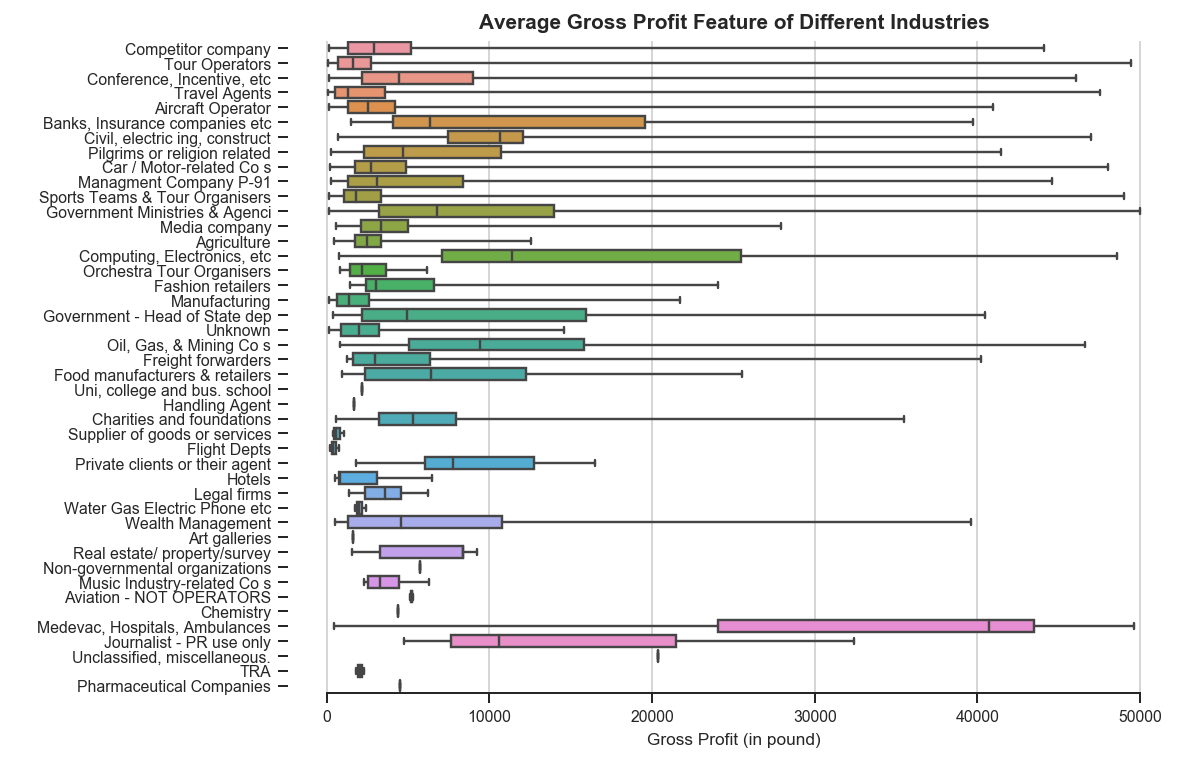

In [17]:
sns.set(style="ticks")
sns.set_context("paper", font_scale=0.9)                                                  
var = 'Industry'
data = pd.concat([df['gross'], df[var]], axis=1)
data.sort_values(by=['gross'], ascending=True)
fig, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='gross', y=var, data=data, whis="range")

ax.xaxis.grid(True)
plt.xlabel("Gross Profit (in pound)")
plt.ylabel(" ")
plt.title('Average Gross Profit Feature of Different Industries', fontsize='large', fontweight='bold')
# plt.savefig('output/Industry.png', dpi=500, box_inches = 'tight')
sns.despine(trim=True, left=True)

#### Converting the high-cardinality categorical variables
- Industry(44 attributes)
- no of sectors(29 attributes)

In [18]:
from category_encoders.hashing import HashingEncoder
from category_encoders import *
from sklearn.compose import ColumnTransformer

In [19]:
he = HashingEncoder(cols = ['Industry', 'no of sectors'])
df = he.fit_transform(df)

## Customer and Total Distance

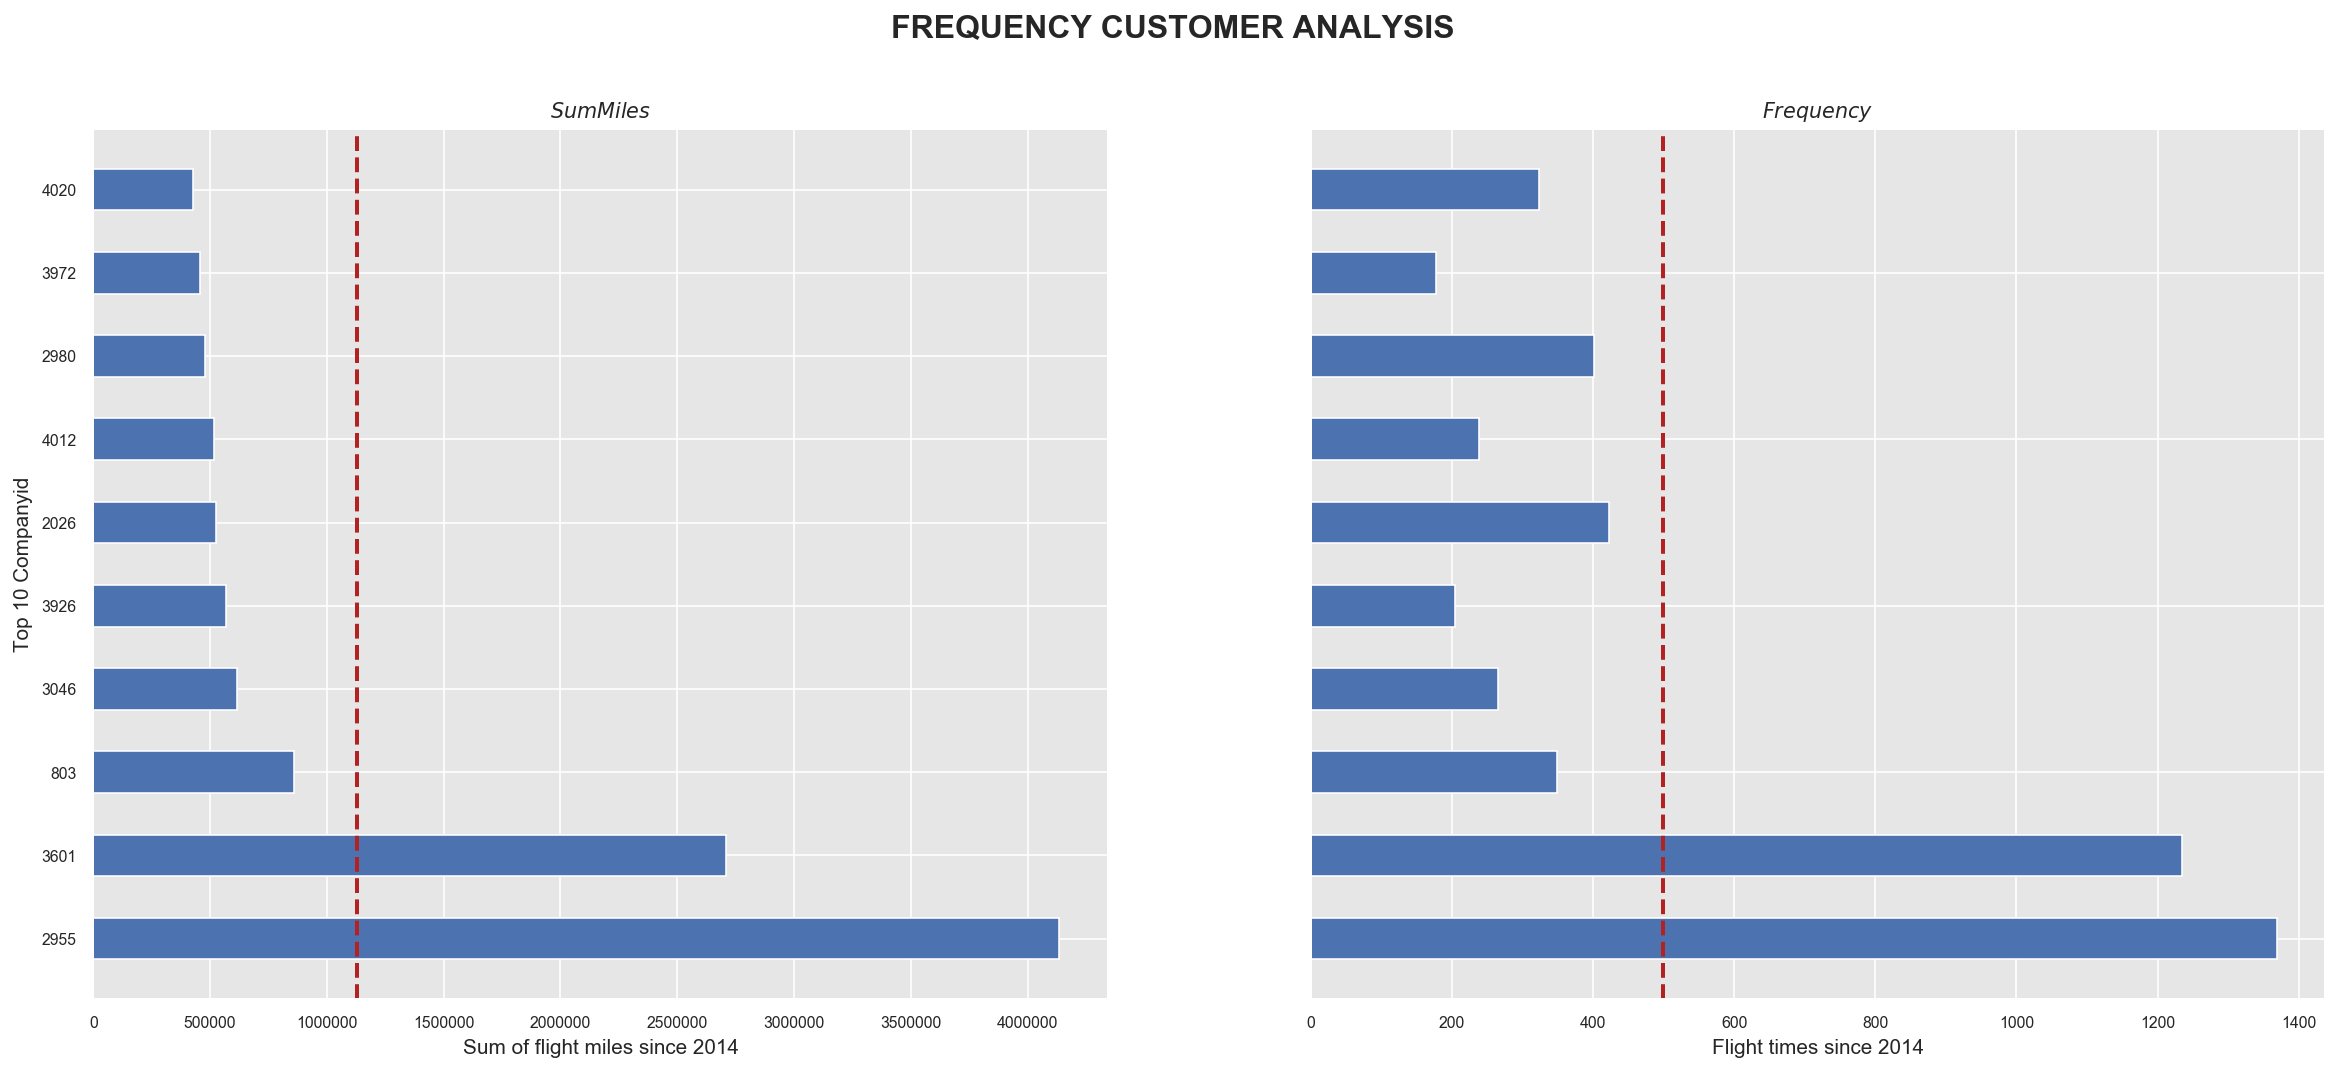

In [20]:
df_cp = df.groupby('companyid')['Total Distance (NMi)'].agg(['sum', 'count']).reset_index().sort_values(by = 'sum', ascending = False)
df_cp.head(5)
df_cp.columns = ['companyid', 'Sum_Miles', 'Frequency']

# plot the purchase frequent of companies
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig = plt.figure(figsize=(20,8))
fig.suptitle('FREQUENCY CUSTOMER ANALYSIS', fontsize= 16, fontweight = 'bold')
ax1 = fig.add_subplot(121)
plt.barh(np.arange(10), df_cp.Sum_Miles[:10], height=0.5, tick_label = df_cp.companyid[:10])
plt.title('$Sum Miles$', fontsize='large')
plt.ylabel('Top 10 Companyid', fontsize='large')
plt.xlabel('Sum of flight miles since 2014', fontsize='large')
miles_average = df_cp.Sum_Miles[:10].mean()
plt.axvline(x = miles_average, color = 'firebrick', linestyle = '--', linewidth =2)

ax2 = fig.add_subplot(122)
plt.barh(np.arange(10), df_cp.Frequency[:10], height=0.5)
plt.title('$Frequency$', fontsize='large')
plt.yticks(visible = False)
plt.xlabel('Flight times since 2014',fontsize='large')
frequency_average = df_cp.Frequency[:10].mean()
plt.axvline(x = frequency_average, color = 'firebrick', linestyle = '--', linewidth =2)
plt.show()

In [21]:
df_cp['Frequency'].mean()

11.97196261682243

In [22]:
df_gross = df.groupby('companyid')['gross'].agg(['sum', 'count']).reset_index().sort_values(by = 'sum', ascending = True)
df_gross.head(5)
df_gross.columns = ['companyid', 'GrossProfit', 'count']

In [23]:
df_gross['log10_GrossProfit'] = np.log10(df_gross['GrossProfit'])

In [24]:
values, bin_edges = np.histogram(df_gross['GrossProfit'], bins=30, density=True)

pdf = values / sum(values)
# print(pdf)
# print(bin_edges)

values1, bin_edges1 = np.histogram(df_gross['log10_GrossProfit'], bins=30, density=True)
pdf1 = values1 / sum(values1)
cdf = np.cumsum(pdf1)

In [25]:
df_gross = df_gross.reset_index(drop=True)

In [82]:
df_gross.loc[:, ['GrossProfit']].mean()

GrossProfit    48194.060979
dtype: float64

In [93]:
len(df_gross[(df_gross['GrossProfit'] > 1000000)])

7

In [26]:
df_gross.loc[:, ['GrossProfit']].apply(lambda x: x.sum())

GrossProfit    5.156765e+07
dtype: float64

In [27]:
df_gross.loc[:1067, ['GrossProfit']].apply(lambda x: x.sum())

GrossProfit    4.637917e+07
dtype: float64

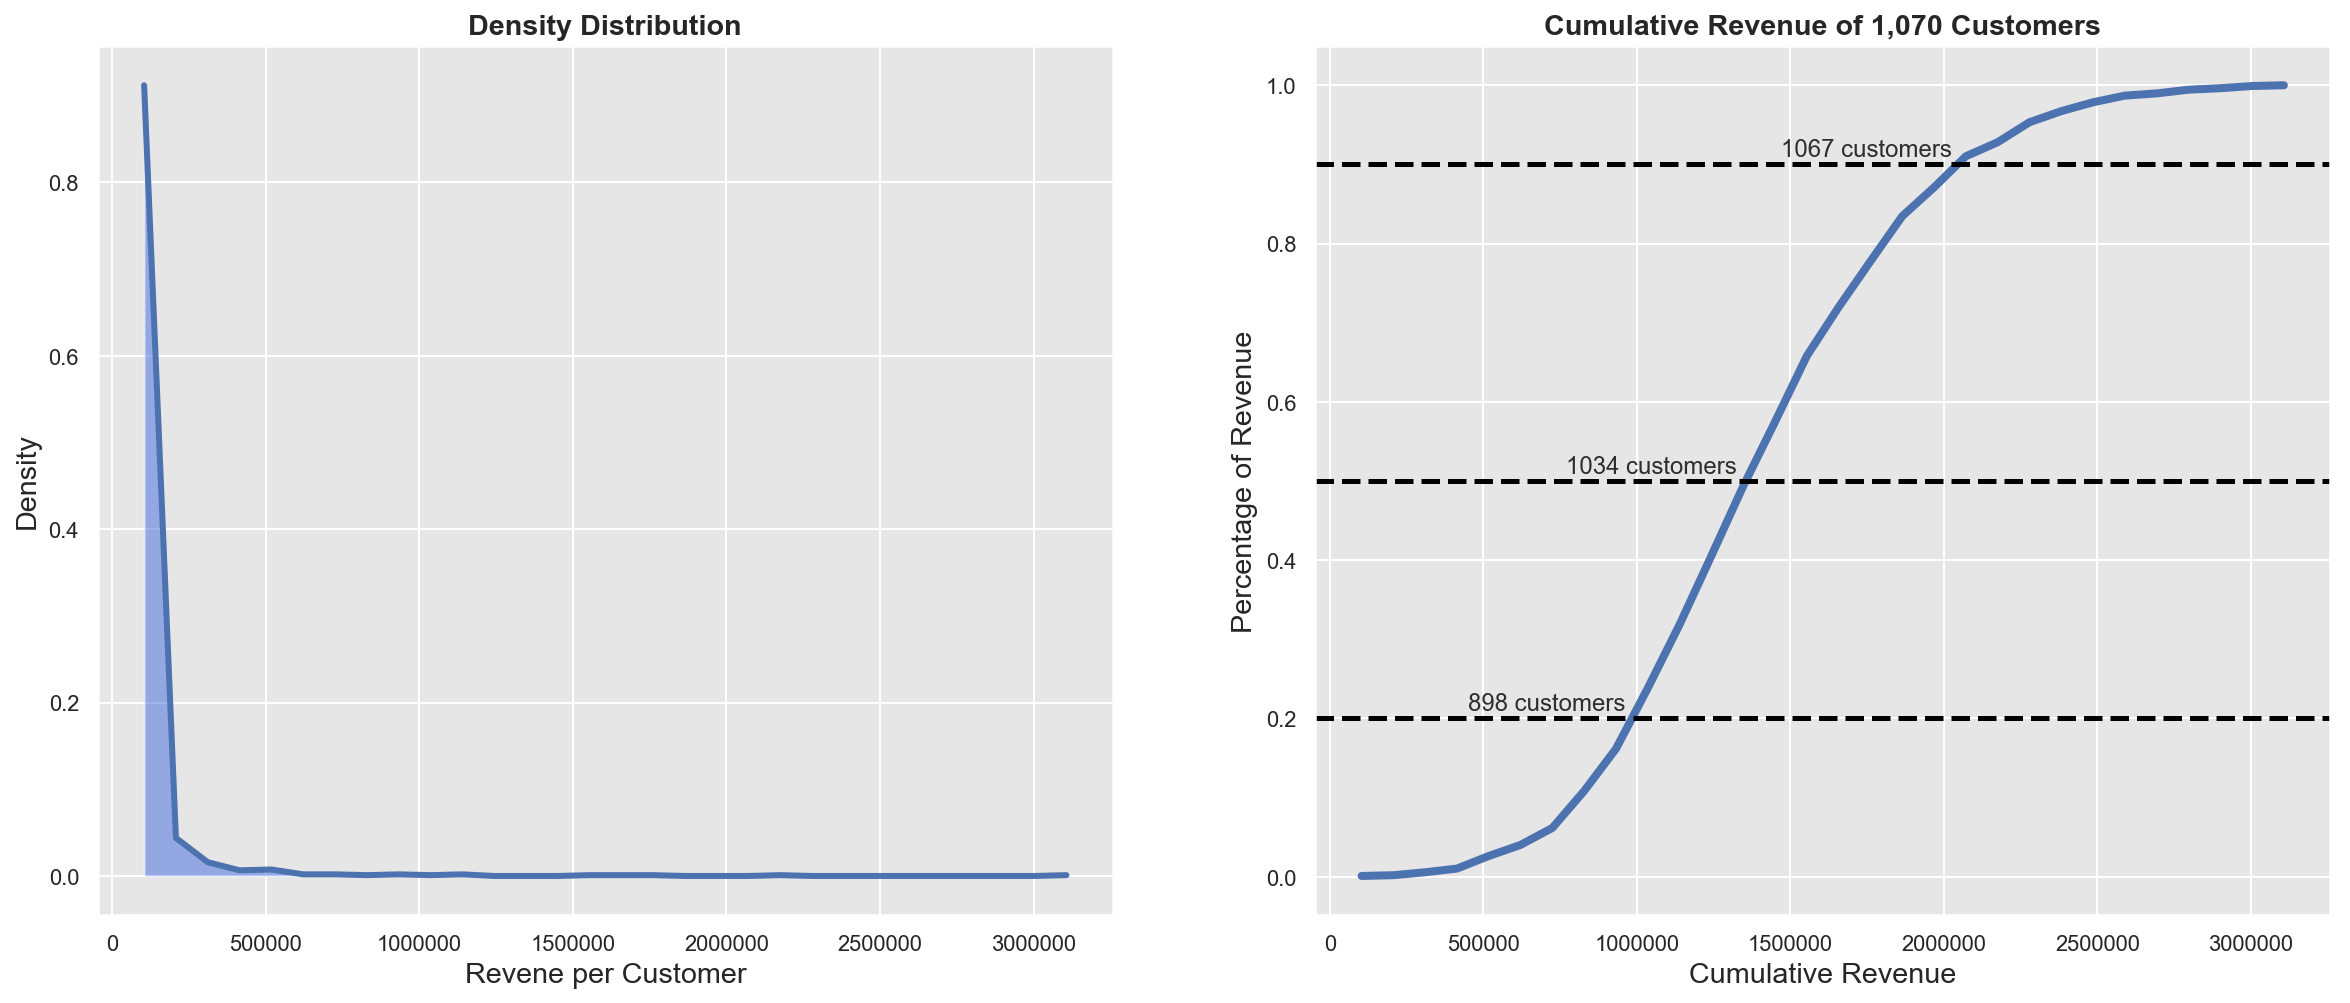

In [101]:
grossmin = df_gross.GrossProfit.min()

fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,2)
plt.plot(bin_edges[1:], cdf, linewidth=4)
plt.axhline(0.2, color='black', linestyle="--") 
plt.text(450000,  0.21,'%d customers' % (898), color = 'black', alpha=0.8)
plt.axhline(0.5, color='black', linestyle="--") 
plt.text(770000,  0.51,'%d customers' % (1034), color = 'black', alpha=0.8)
plt.axhline(0.9, color='black', linestyle="--") 
plt.text(1470000,  0.91,'%d customers' % (1067), color = 'black', alpha=0.8)
plt.xlabel('Cumulative Revenue', fontsize='large')
plt.ylabel('Percentage of Revenue', fontsize='large')
plt.title('Cumulative Revenue of 1,070 Customers', fontsize='large', fontweight='bold')

plt.subplot(1,2,1)
plt.plot(bin_edges[1:], pdf, linewidth=3)
plt.fill_between(bin_edges[1:], pdf,  facecolor='royalblue', alpha=0.5)
plt.xlabel('Revene per Customer', fontsize='large')
plt.ylabel('Density', fontsize='large')
plt.title('Density Distribution', fontsize='large', fontweight='bold')
plt.show()

## Operators and orders
- Determine the number of flights that has done by each operators

In [29]:
# 2.2 customer, operators and flights
pd.DataFrame([{'operators':len(df['ownerid'].value_counts()),
               'flights':len(df['enqid'].value_counts()),
               'customers':len(df['companyid'].value_counts()),
              }], columns = ['operators', 'flights', 'customers'], 
             index = ['quantity'])

,operators,flights,customers
quantity,80,11483,1070


In [30]:
pd.DataFrame([{'flights':len(df['enqid'].value_counts()),
               'customers':len(df['companyid'].value_counts()),
              }], columns = ['operators', 'flights', 'customers'], 
             index = ['quantity'])

,operators,flights,customers
quantity,NaN,11483,1070


#  Insight on aircraft categories
- In this section, I intend to use the content of this variable in order to group the products into different categories.

In [31]:
# # Above all, it has been seen that some values of the Aircraft code variable indicate a particular transaction.
df1 = pd.DataFrame(df, columns= ['companyid', 'Aircraft code', 'enqid', 'Total Flight Time (Dec)'])
s = ['Aircraft code']
df2 = df1.drop(columns=s, axis=1)

for i in s:
    df2 = df2.join(df1[i].str.split(',', expand = True).stack().reset_index(level=1, drop=True).rename(i))
df2 = df2.reset_index(drop = True)
df2 = df2[df2['Aircraft code'].notnull()]

# Althernative drop the companyid to check the most popular aircraft
temp = df2.groupby(by=['companyid', 'Aircraft code'], as_index=False)['enqid'].count()
nb_flights_per_cp = temp.rename(columns = {'enqid':'Number of flights'})
nb_flights_per_cp.sort_values('Number of flights', ascending=False).head()

,companyid,Aircraft code,Number of flights
1399,2955,A320-200,535
1931,3601,A320-200,425
1403,2955,B737-800,321
1485,3046,B737-400,264
1424,2980,E175,248


## Aircraft Description
- I extract from the Aircraft code variable the information to a single column that will prove useful.

In [32]:
# import nltk
# nltk.download('popular')

def order_inventory(dataframe, colonne='Aircraft code'):
    category_keys = []
    keywords_roots = dict()
    keywords_select = dict()
    count_keywords = dict()

    for t in dataframe[colonne]:
        if t in keywords_roots:
            keywords_roots[t].add(t)
            count_keywords[t] += 1
        else:
            keywords_roots[t] = {t}
            count_keywords[t] = 1
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
        
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [33]:
# Get the count_keywords and keywords_select to cluster the aircraft
keywords, keywords_roots, keywords_select, count_keywords = order_inventory(df2)

Nb of keywords in variable 'Aircraft code': 110


In [34]:
nb_flights_per_cp['VIP'] = nb_flights_per_cp['Aircraft code'].apply(lambda x:int('VIP' in x))
display(nb_flights_per_cp.sort_values('VIP', ascending=False).head())

n3 = nb_flights_per_cp['VIP'].sum()
n4 = nb_flights_per_cp.shape[0]
print('Number of orders is VIP: {}/{} ({:.2f}%) '.format(n3, n4, n3/n4*100))

,companyid,Aircraft code,Number of flights,VIP
177,425,B735-VIP,1,1
61,177,B146-VIP,2,1
2411,4067,B735-VIP,1,1
1466,3034,B735-VIP,1,1
1785,3423,B757-VIP,1,1


Number of orders is VIP: 70/2580 (2.71%) 


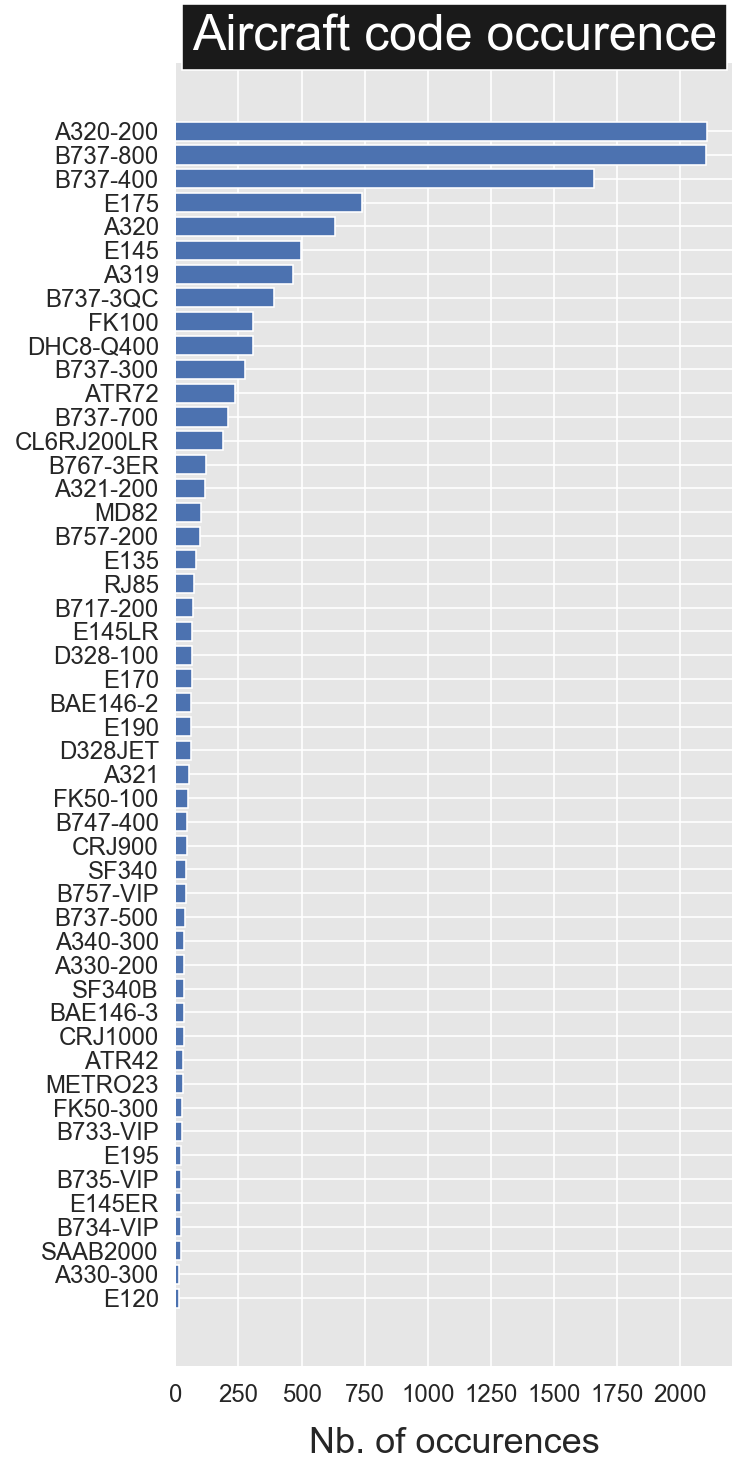

In [35]:
# convert the count_keywords dictionary in to a list
list_aircraft = []
for k, v in count_keywords.items():
    list_aircraft.append([keywords_select[k], v])
    # to sort the keywords according to their occurences
list_aircraft.sort(key = lambda x:x[1], reverse=True)
liste = sorted(list_aircraft, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(5,12))
y_axis = [i[1] for i in liste[:50]]
x_axis = [k for k,i in enumerate(liste[:50])]
x_label = [i[0] for i in liste[:50]]
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
plt.title("Aircraft code occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
fig.savefig('output/aircraft.png', dpi=300)
plt.show()

## Defining aircraft categories
- The list that was obtained more than 200 keywords and the most frequent aircraft appears in more than 5000 times. However, while examinating the content of the list, I discard some useless names from the follows.

In [36]:
df = df[df['Aircraft code'].notnull()]

NEW_keywords, NEW_keywords_roots, NEW_keywords_select, NEW_count_keywords = order_inventory(df)

Nb of keywords in variable 'Aircraft code': 374


In [37]:
# Discard if the list has the null values
list_aircraft = []
for k, v in NEW_count_keywords.items():
    words = NEW_keywords_select[k]
    if words is None:
        continue
    list_aircraft.append([words, v])

list_aircraft.sort(key = lambda x:x[1], reverse = True)
print('Conserved:', len(list_aircraft))

Conserved: 374


### Data Encoding
- I will use thes keywords to create groups of aircraft. I define the X matrix that indicates the words contained in the aircraft type of the products using the one-hone-encoding principle.

In [38]:
liste_airplane = df['Aircraft code'].unique()

X = pd.DataFrame()
for key, occurence in list_aircraft:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_airplane))

- In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the travel time range of the aircraft:

In [53]:
threshold = [-0.6, 2.15, 2.95, 3.9, 4.9, 6.8]
#  [(0.249, 2.66] < (2.66, 3.58] < (3.58, 4.75] < (4.75, 6.58] < (6.58, 8.5] < (8.5, 95.42]]                                                                                        
label_cols = []
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    label_cols.append(col)
    X.loc[:, col] = 0
    
for i, air in enumerate(liste_airplane):
    p = df[df['Aircraft code'] == air]['Total Flight Time (Dec)'].mean()
    j = 0
    while p > threshold[j]:
        j += 1
        if j == len(threshold): 
            break
    X.loc[i, label_cols[j-1]] = 1

In [54]:
print('{:<8} {:<20} \n'.format('gamme', 'number.aircrafts') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
    print('{:<10} {:<20}'.format(col, X.loc[:, col].sum()))

gamme    number.aircrafts     
--------------------
-0.6<.<2.15 61                  
2.15<.<2.95 63                  
2.95<.<3.9 66                  
3.9<.<4.9  60                  
4.9<.<6.8  61                  
.>6.8      63                  


### Creating clusters of aircrafts
- I will group the aircrafts into different classes. In the case of meetrics with binary encoding, the most suitable metrics for the calculation of distances is the Hamming's metrics.
- Kmeans methods of sklearn uses a Euclidean distance that can be used, but not the best in the case of categorical variable.

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score

In [57]:
matrix = X.as_matrix()
y_silhouette_score = []
CH_score = []

for n_clusters in range(3,11):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, random_state=1)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
#     print(cluster_labels)
#     print(clusterer.cluster_centers_)
#     print(clusterer.labels_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed 
    silhouette_avg = silhouette_score(matrix, clusters)
    y_silhouette_score.append(silhouette_avg)
    
    calinskiharabaz_avg = calinski_harabaz_score(matrix, clusters)
    CH_score.append(calinskiharabaz_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.18233233584370617
For n_clusters = 4 The average silhouette_score is : 0.161832061550313
For n_clusters = 5 The average silhouette_score is : 0.17719873240547326
For n_clusters = 6 The average silhouette_score is : 0.2058653848091013
For n_clusters = 7 The average silhouette_score is : 0.1951105800038194
For n_clusters = 8 The average silhouette_score is : 0.19048397576301565
For n_clusters = 9 The average silhouette_score is : 0.16876299220317884
For n_clusters = 10 The average silhouette_score is : 0.18119644391330839


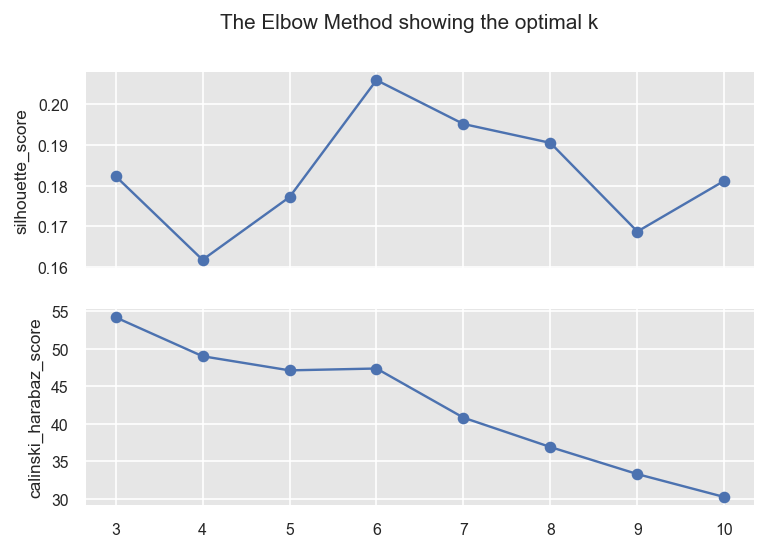

In [58]:
fig, axs = plt.subplots(2, sharex = True)
fig.suptitle('The Elbow Method showing the optimal k')
axs[0].plot(range(3, 11), y_silhouette_score, '-o')
axs[0].set(ylabel = 'silhouette_score')
axs[1].plot(range(3, 11), CH_score, '-o')
axs[1].set(ylabel = 'calinski_harabaz_score')
plt.grid(True)
plt.savefig('optimal k.png')
plt.show()

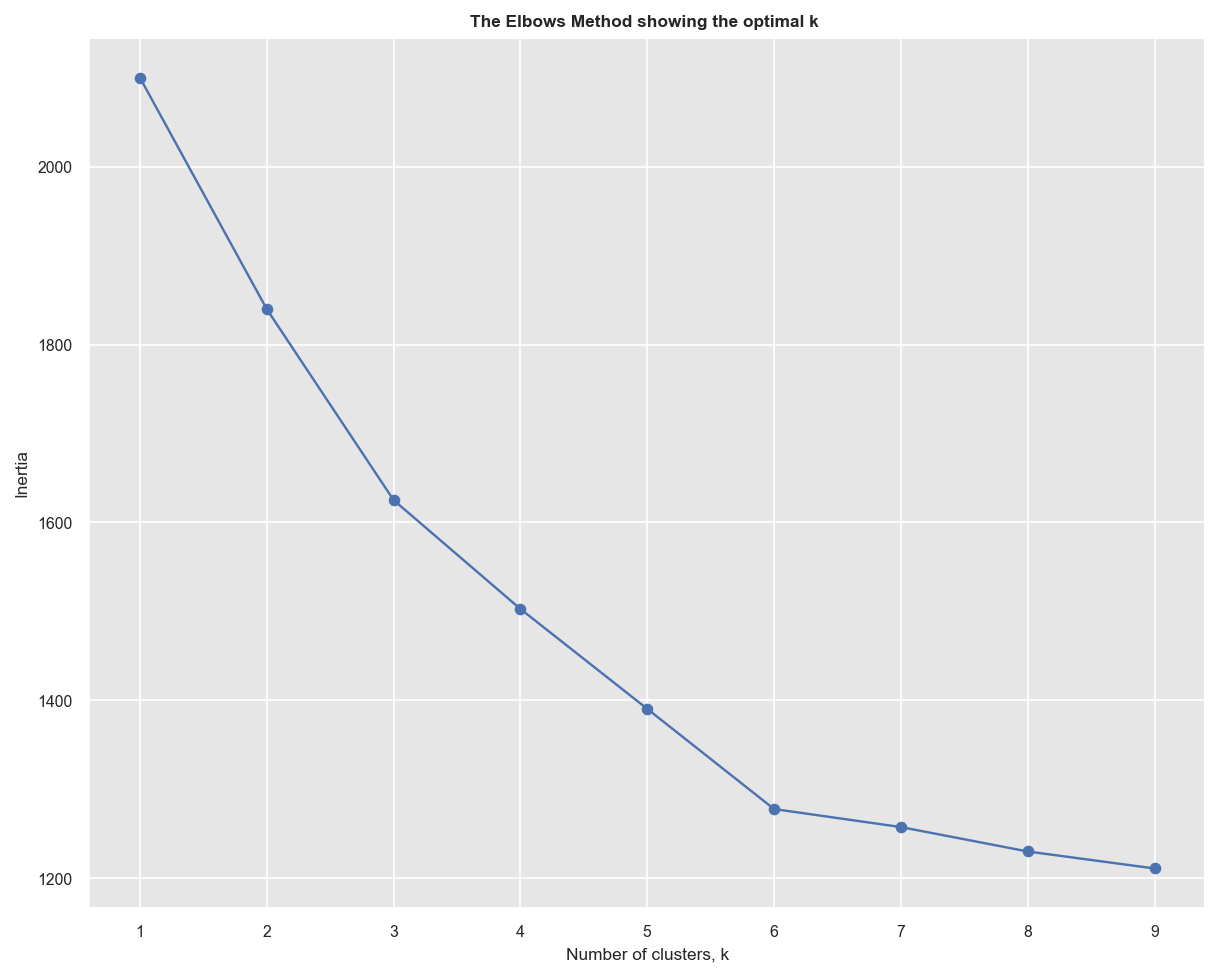

In [59]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(matrix)
    inertias.append(model.inertia_)

plt.figure(figsize=(10,8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('The Elbows Method showing the optimal k ', fontweight='bold')
plt.xticks(ks)
# plt.savefig('Number of clusters.png')
plt.show()

In [60]:
# scores of 0.2+0.05 will be obtained for all clusters with n+clusters >3 
# I choose to separate the dataset into 5 clusters in order to ensuer a good classigicatin at every run
n_clusters = 6
silhouette_avg = -1

while silhouette_avg < 0.15:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, 
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 0.20599778639240596


### Characterizing the content fo clusters
- check th enumber of elements in every class

In [61]:
pd.Series(clusters).value_counts()

0    68
5    65
2    63
3    61
1    61
4    56
dtype: int64

#### Word Cloud
- Have a look at the type of objects that each cluster represents in order to determine which keywords are the most frequent in each of them

In [62]:
from wordcloud import WordCloud, STOPWORDS

In [63]:
liste = pd.DataFrame(liste_airplane)
liste_words = [word for (word, occurence) in list_aircraft]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

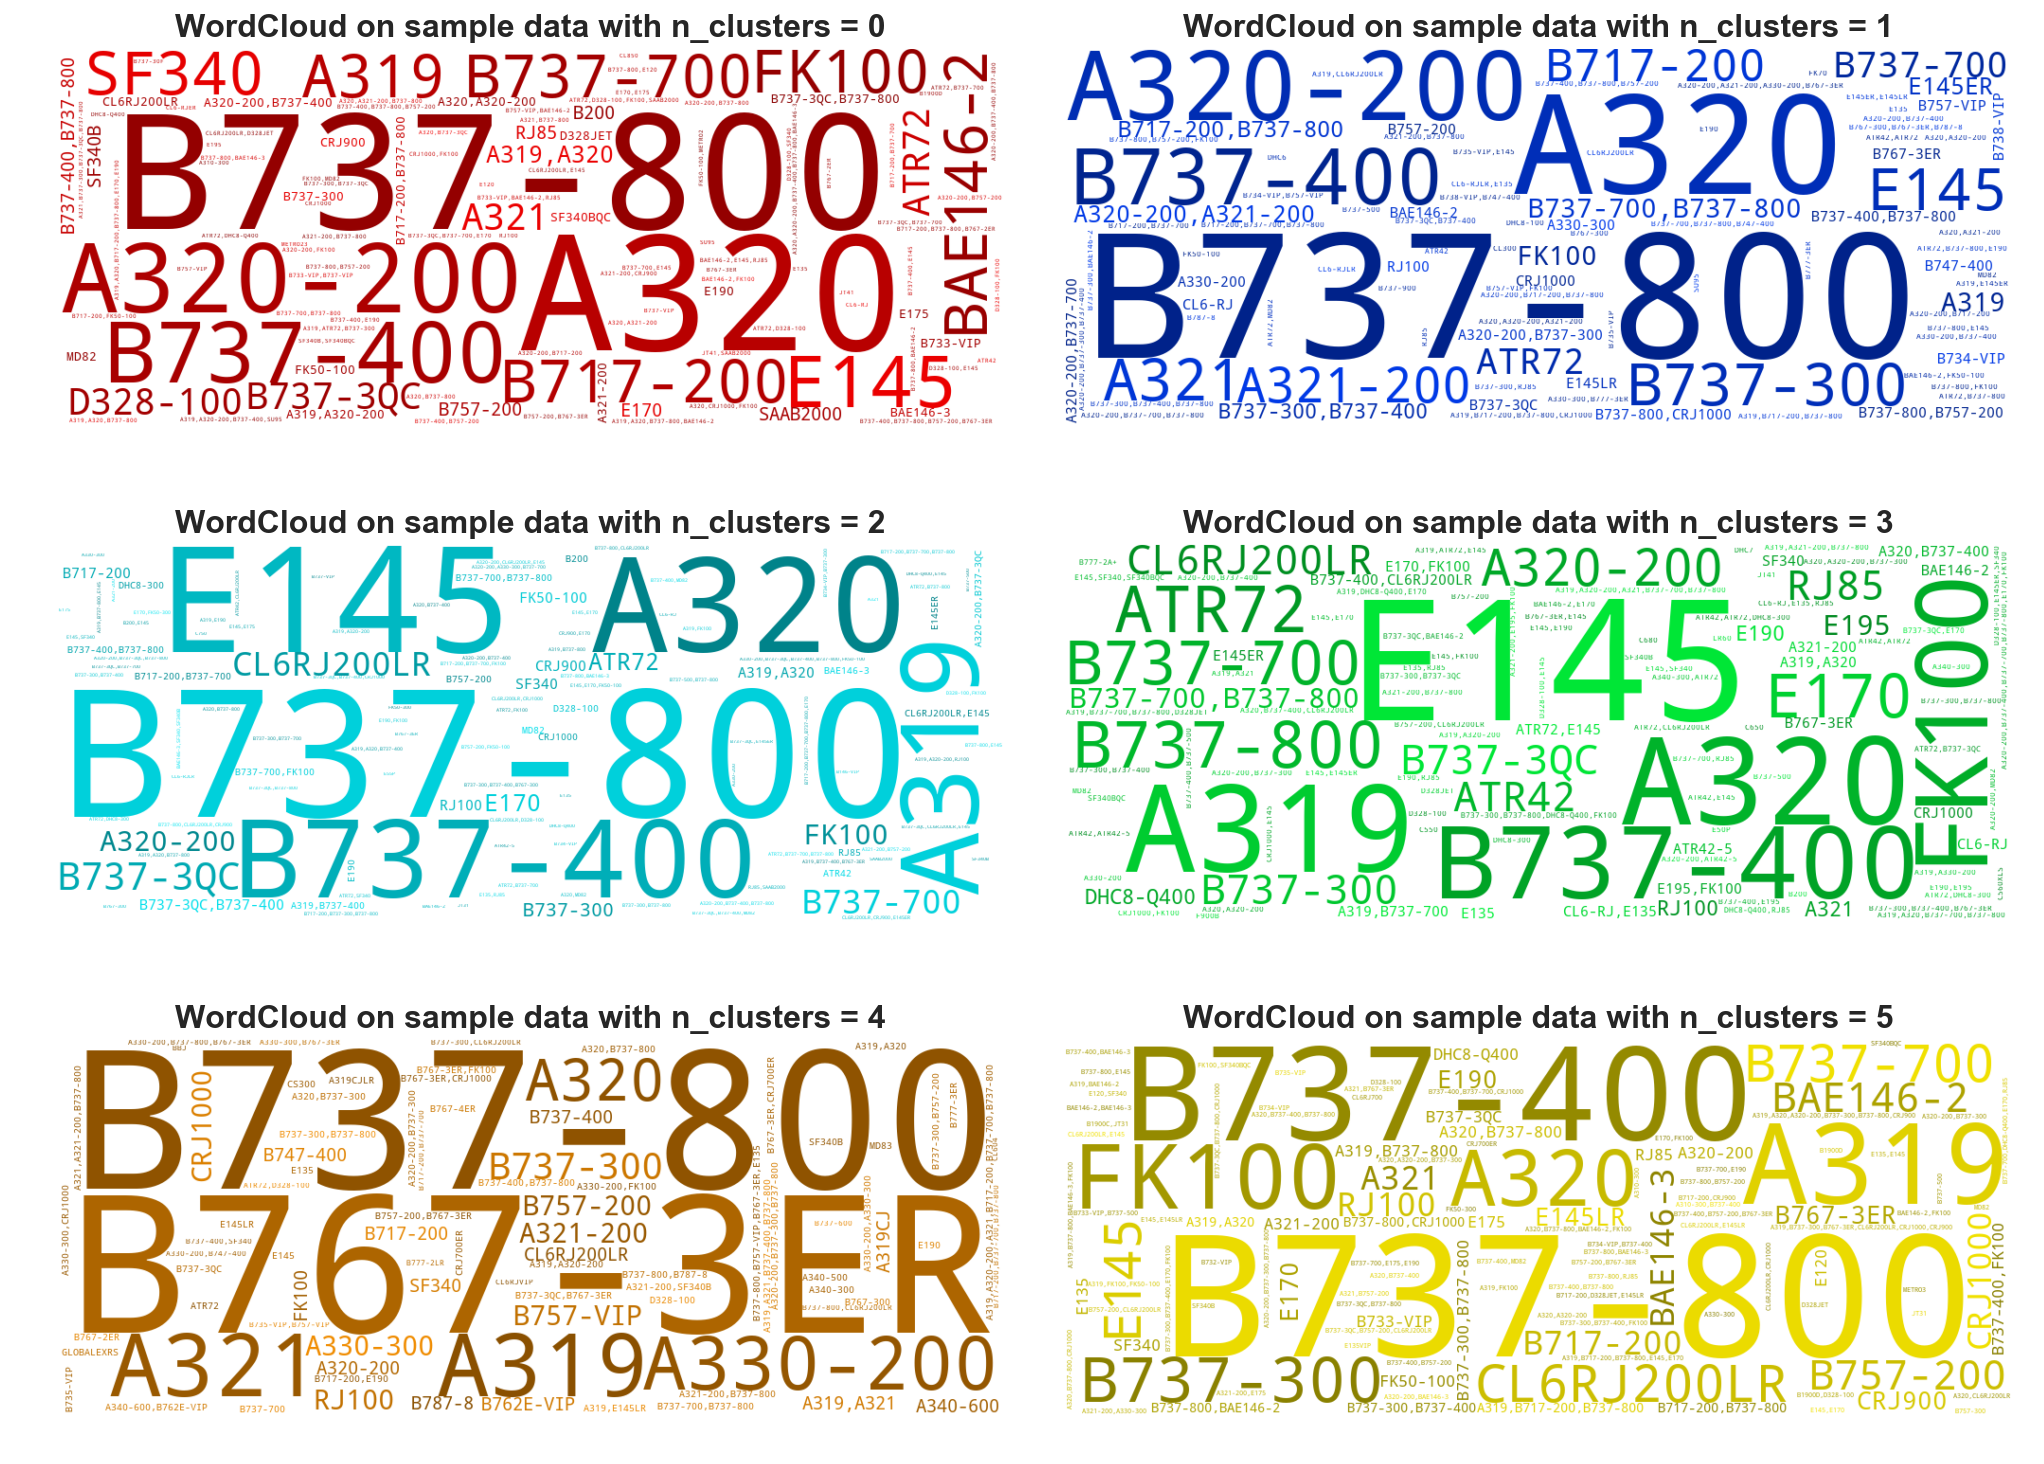

In [64]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:300]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    wordcloud = WordCloud(width=1000,height=400, background_color='white', 
                          relative_scaling=1, color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(words)
    # plot the WordCloud image
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.tight_layout(pad = 0)
    plt.title("WordCloud on sample data with n_clusters = {}".format(increment-1),
              fontsize=16, fontweight='bold')
    plt.savefig('WordCloud.png')

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)    

- From this representation, we can see cluters contains objects with sort of connections.
- Nevertheless, many words appear in various clusters and it is therefore difficlut to clearly distinguish them.

#### Principal Component Analysis
- In order to ensure these clusters are truely distinct, I perfrom a PCA given the large number of variable of the initial matrix.

In [65]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

In [66]:
pca = PCA().fit(matrix)
# Represents data matrix is used to train PCA model
pca_samples = pca.transform(matrix)
features = range(pca.n_components_)
# Transform data matrix into the decomposited data 

# print(pca.explained_variance_ratio_)
# print(pca.explained_variance_)

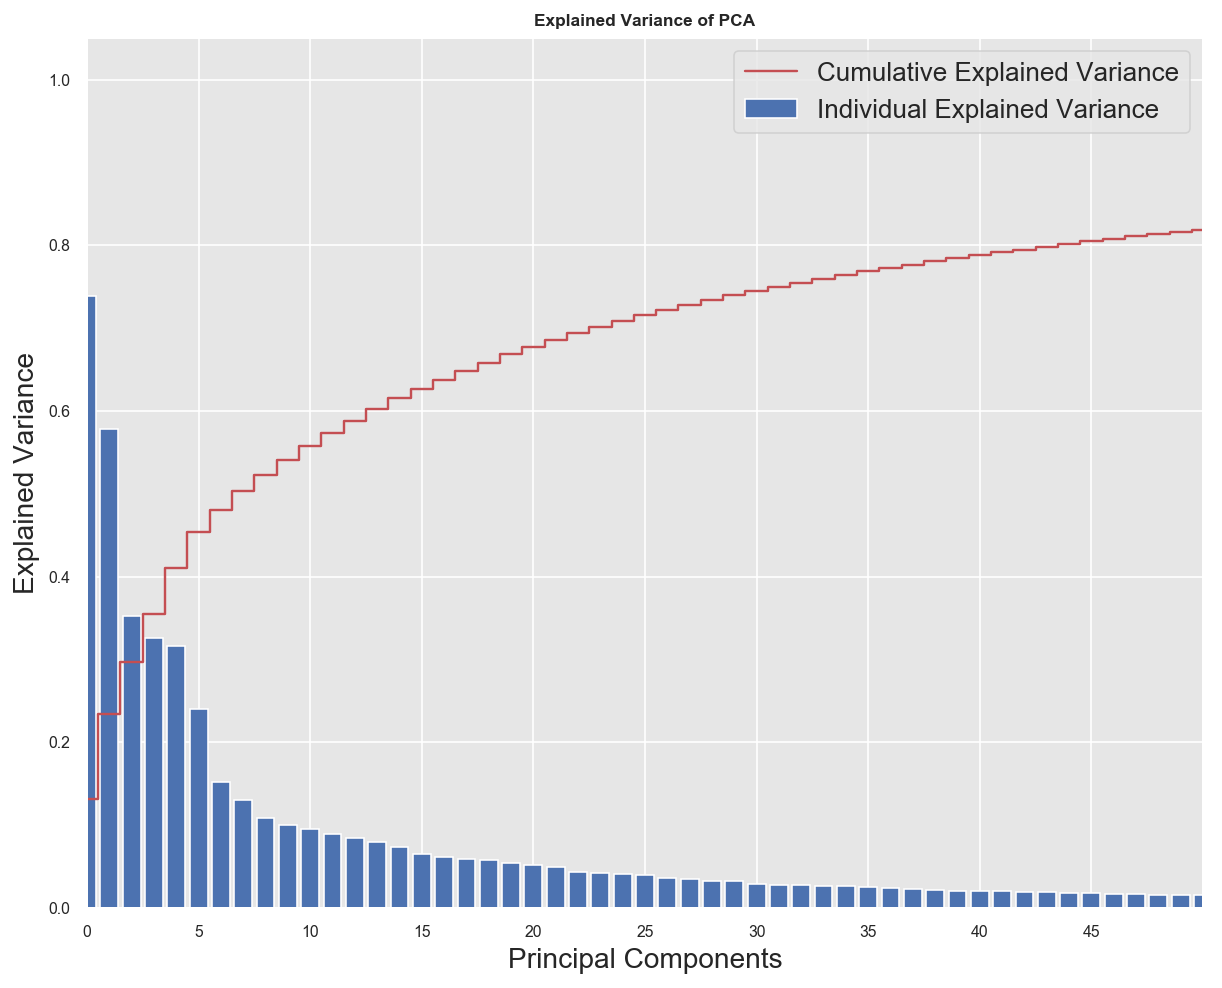

In [67]:
plt.figure(figsize=(10,8))
plt.step(features, pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance', color='r')
plt.bar(features, pca.explained_variance_,label='Individual Explained Variance')
plt.ylabel('Explained Variance', fontsize=14)
plt.xlabel('Principal Components', fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.title('Explained Variance of PCA', fontweight='bold')
plt.xticks(np.arange(0, 50, step=5))
plt.xlim(0,50)
fig.savefig('PCA.png')
plt.show()

- We need only limited components to explain 90% of variance of the data since this decomposition is only performed to visualize the data.

In [68]:
aircraft_pca = PCA(n_components=50).fit_transform(matrix)
air_mat = pd.DataFrame(aircraft_pca)
air_mat['Cluster'] = pd.Series(clusters)

In [69]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

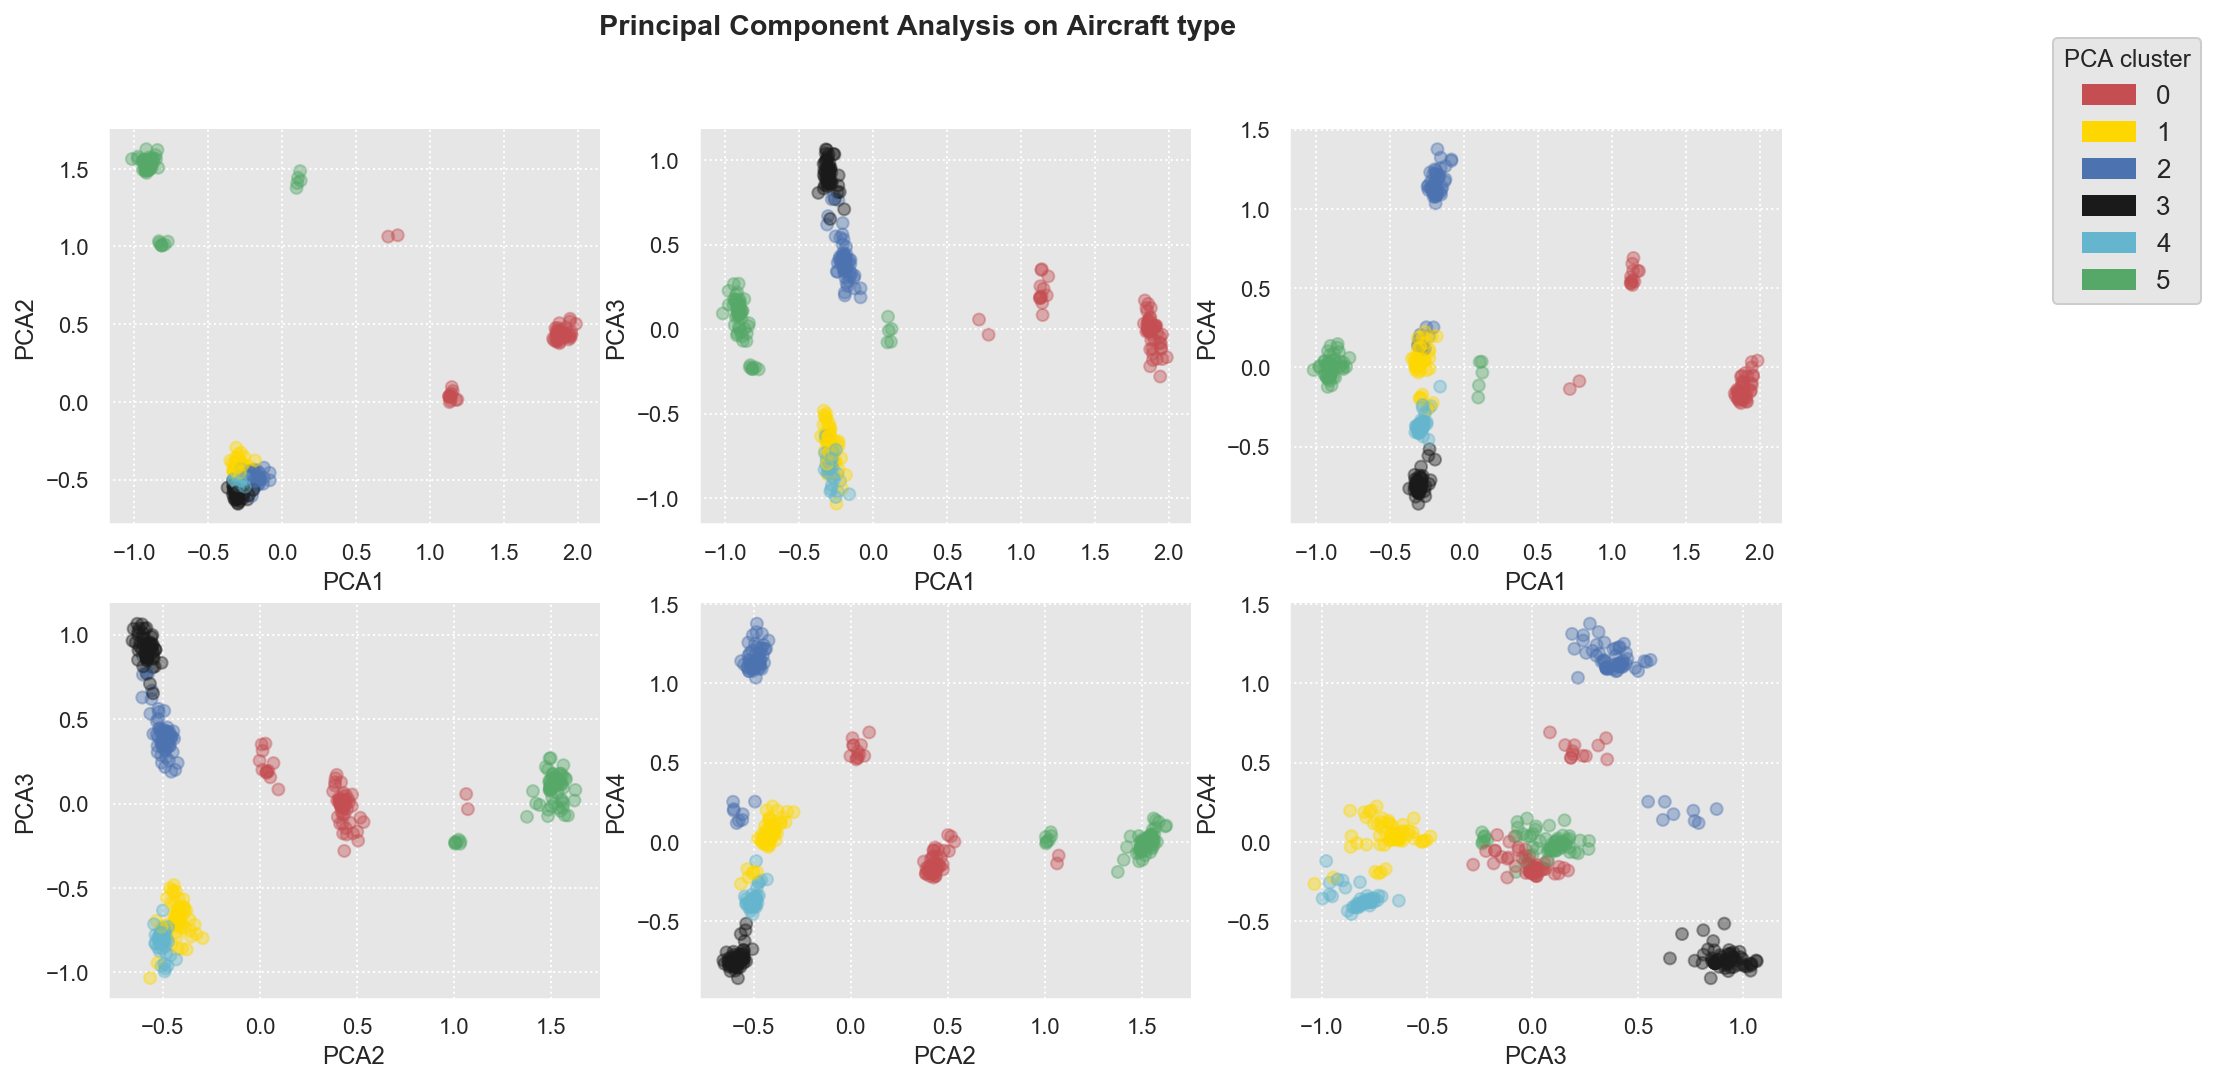

In [70]:
Label_Map = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
# Assign a color to each mat
label_color = [Label_Map[i] for i in air_mat['Cluster']]

fig = plt.figure(figsize = (15, 8))
increment = 0
for i in range(4):
    for j in range(i+1, 4):
        increment += 1 
        ax = fig.add_subplot(2, 3, increment)
        ax.scatter(air_mat[i], air_mat[j], c=label_color, alpha=0.4)
        plt.ylabel('PCA{}'.format(j+1), fontsize=12)
        plt.xlabel('PCA{}'.format(i+1), fontsize=12)
        ax.yaxis.grid(linestyle=':')
        ax.xaxis.grid(linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9:
            break
    if increment == 9:
        break
        
comp_handler = []

for i in range(6):
    comp_handler.append(mpatches.Patch(color=Label_Map[i], label=i))
plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), title='PCA cluster', frameon=True, fontsize= 13, framealpha=1, bbox_transform=plt.gcf().transFigure)
fig.suptitle('Principal Component Analysis on Aircraft type', fontsize='large', fontweight='bold')
plt.savefig('PCA cluster.png')
plt.show()

# Customer Categories

## Formatting data
- In the previous section, the different aircrafts were grouped in 6 clusters. In order to feed into the ML model, the first step consists in introducing this formation into the dataframes. To do this, I create the cateforical variable categ_aircraft where I indicate the cluster of each aircraft.

In [71]:
corr = dict()
for k, v in zip(liste_airplane, clusters):
    corr[k] = v
# Create a col named categ_aircraft
df['categ_aircraft'] = df.loc[:, 'Aircraft code'].map(corr)

### Grouping Aircraft combination
- I decide to create the categ_N variables(with N ∈ [0:5]) that contains the amount spent in each aircraft category.

In [72]:
for i in range(6):
    col = 'categ_{}'.format(i)
    temp = df[df['categ_aircraft'] == i]
    gross_temp = temp['gross']
    gross_temp = gross_temp.apply(lambda x:x if x>0 else 0)
    df.loc[:, col] = gross_temp
    df[col].fillna(0, inplace=True)
    
df[['categ_aircraft', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4','categ_5']][:5]

,categ_aircraft,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5
0,0,4230.814787,0.0,0.0,0.00000,0.0,0.000000
1,0,4230.814787,0.0,0.0,0.00000,0.0,0.000000
2,0,4230.814787,0.0,0.0,0.00000,0.0,0.000000
3,3,0.000000,0.0,0.0,38328.97753,0.0,0.000000
4,5,0.000000,0.0,0.0,0.00000,0.0,846.888926


- Up to now, the gross related to a single order was split over 6 lines of the dataframe.

In [73]:
# temp = df.groupby(by=['companyid', 'enqid'], as_index=False)['gross'].mean()
# flight_price = temp.rename(columns = {'TotalPrice':'Flight Price'})

# for i in range(6):
#     col = 'categ_{}'.format(i)
#     temp = df.groupby(by=['companyid', 'enqid'], as_index=False)[col].mean()
#     flight_price.loc[:,col] = temp

# def new_col(colonne):
#     df[colonne] = df[colonne].astype('int64')
#     temp = df.groupby(by=['companyid', 'enqid'], as_index=False)[colonne].mean()
# #     df.drop(colonne, axis=1, inplace=True)
#     flight_price.loc[:, colonne] = pd.to_datetime(temp[colonne])
#     # flight_price = flight_price[flight_price['gross'] > 0]
#     flight_price.sort_values('companyid', ascending=True)[:5]

# new_col(colonne='booked date')
# new_col(colonne='Creation Date')
# new_col(colonne='Flight date')

In [74]:
# temp = df.groupby(by=['companyid', 'enqid'])['Country']

In [75]:
# def new_col2(colonne):
#     df[colonne] = df[colonne].astype('int64')
#     temp = df.groupby(by=['companyid', 'flightid'], as_index=False)[colonne].mean()
# #     df.drop(colonne, axis=1, inplace=True)
#     flight_price.loc[:, colonne] = pd.DataFrame(temp[colonne])
#     flight_price.sort_values('companyid', ascending=True)[:5]

# new_col2(colonne='Country')
# new_col2(colonne='Industry')

### Separation of date over time
- One of the obejectives will be to develop a model capable of characterizing and anticipating the habits of customers visiting the site. In order to be able to test the model lin a realistic way, I split the data set by retaining the 70% of months to develop the model and the following 30% months to test it.

In [76]:
# train_df = flight_price[flight_price['Creation Date'] < datetime.date(2017,10,1)]
# test_df = flight_price[flight_price['Creation Date'] >= datetime.date(2017,10,1)]

### Consumer Order Combinations
- I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits. 

In [77]:
# transactions_per_user = flight_price.groupby(by=['companyid'])['gross'].agg(['count', 'min', 'max', 'mean', 'sum'])
# for i in range(5):
#     col = 'categ_{}'.format(i)
#     transactions_per_user.loc[:, col] = flight_price.groupby(by=['companyid'])[col].sum() / transactions_per_user['sum']*100
    
# transactions_per_user.reset_index(drop=False, inplace=True)
# flight_price.groupby(by=['companyid'])['categ_0'].sum()
# transactions_per_user.sort_values('companyid', ascending=True)[:5]

- Finally, I defined the three additional variables that gives the number of days elpased since the first enrollment (ENROLLMENT_TO_END), the number of days since the last purchase (LAST_TO_END), and the sum miles (SEG_KM_SUM).

### Features Removal

In [78]:
df.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'enqid', 'Contactid', 'ownerid', 'companyid', 'booked date',
       'creation date', 'Flight date', 'Flight Year', 'Aircraft code',
       'Total Flight Time (Dec)', 'Total Distance (NMi)', 'gross',
       'Round_trip', 'ProfitMargin(%)', 'gross_log', 'Distance_log',
       'FlightTime_log', 'Scaled_gross_log', 'Scaled_Distance_log',
       'Scaled_FlightTime_log', 'Country_France', 'Country_Germany',
       'Country_Italy', 'Country_Monaco', 'Country_Other', 'Country_Sweden',
       'Country_Switzerland', 'Country_Turkey', 'Country_United Kingdom',
       'Country_United States', 'Product_Tour Ops', 'passengersRange_1',
       'passengersRange_2', 'passengersRange_3', 'categ_aircraft', 'categ_0',
       'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5'],
      dtype='object')

In [79]:
df = df.drop(['enqid', 'Contactid', 'ownerid', 'booked date', 'creation date', 'Flight date', 'Flight Year', 'Aircraft code', 'gross_log', 'Distance_log', 'FlightTime_log', 'Total Flight Time (Dec)', 'Total Distance (NMi)', 'gross'], axis=1)

df = df.rename(columns = {'col_0':'HashEncode_0', 'col_1':'HashEncode_1', 'col_2':'HashEncode_2', 'col_3':'HashEncode_3', 'col_4':'HashEncode_4', 'col_5':'HashEncode_5', 'col_6':'HashEncode_6', 'col_7':'HashEncode_7'})

In [80]:
df.to_csv('CL dataset.csv', index=False)